In [1]:
#!/sciclone/home20/dchendrickson01/.conda/envs/tfcgpu/bin/python

#
#  Works in CPU Mode not GPU
#

#Standard Header used on the projects
# %%



#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import os as os
import random
import multiprocessing
from joblib import Parallel, delayed

import pywt
from pywt._extensions._pywt import (DiscreteContinuousWavelet, ContinuousWavelet,
                                Wavelet, _check_dtype)
from pywt._functions import integrate_wavelet, scale2frequency
from time import time as ti
import datetime

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import  EarlyStopping
 
import cv2
from sklearn.model_selection import train_test_split
#import tensorflow.keras_metrics as km
  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix

import platform

HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
    

if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/sciclone/scr10/dchendrickson01/CraneData/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "SmallCopy\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "SmallCopy\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'SmallCopy/'
    

scales = 500
#img_height , img_width = scales, 200
DoSomeFiles = True
NumberOfFiles = 15
SmoothType = 3  # 0 = none, 1 = rolling average, 2 = rolling StdDev
TrainEpochs = 3
WaveletToUse = 'beta'

num_cores = multiprocessing.cpu_count() -1
SensorPositonFile = rootfolder + 'SensorStatsSmall.csv'

if Computer == "SciClone" or Computer == "LinLap":
    SaveModelFolder = rootfolder + 'SavedModel/'
else:
    SaveModelFolder = rootfolder + 'SavedModel\\'

files = os.listdir(folder)
if DoSomeFiles: files = random.sample(files,NumberOfFiles)

OutputVectors = np.genfromtxt(open(SensorPositonFile,'r'), delimiter=',',skip_header=1,dtype=int, missing_values=0)

In [2]:
import CoreFunctions as cf

In [3]:

AllAccels = Parallel(n_jobs=num_cores)(delayed(cf.getAcceleration)(file) for file in files)
Flattened = []
for j in range(np.shape(AllAccels)[0]):
    if AllAccels[j][0] == False:
        print(j,AllAccels[j][1])
    else: 
        Flattened.append(AllAccels[j])
print('Have Data')

Have Data


/sciclone/home20/dchendrickson01/.conda/envs/tfcgpu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [4]:
MetaData = []  #np.asarray([],dtype=object)
DataOnlyMatrix = np.asarray([],dtype=object)
for j in range(np.shape(AllAccels)[0]):
    if AllAccels[j][0] == False :
        if AllAccels[j][1][4:9] =='Accel':
            print(j,AllAccels[j][1])
    else: 
        for k in range(3):
            MetaData.append([AllAccels[j][k][0], AllAccels[j][k][1], AllAccels[j][k][3], AllAccels[j][k][4]])
            if np.size(DataOnlyMatrix) == 0:
                    DataOnlyMatrix =np.matrix(AllAccels[j][k][2])
            else:
                    DataOnlyMatrix = np.concatenate((DataOnlyMatrix,np.matrix(AllAccels[j][k][2])),axis=0)

MetaData = np.matrix(MetaData)

In [5]:
def resizeImage(FP):
    res = cv2.resize(FP, dsize=(int(np.shape(FP)[0]/2), int(np.shape(FP)[1]/6)), interpolation=cv2.INTER_CUBIC)

    return res

In [6]:
AllAccels = cf.KalmanGroup(DataOnlyMatrix)

/sciclone/home20/dchendrickson01/.conda/envs/tfcgpu/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sciclone/home20/dchendrickson01/.conda/envs/tfcgpu/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sciclone/home20/dchendrickson01/.conda/envs/tfcgpu/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sciclone/home20/dchendrickson01/.conda/envs/tfcgpu/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could

In [7]:
maxes = np.amax(AllAccels[:,500:], axis = 1)
mins = np.amin(AllAccels[:,500:], axis = 1)

Keep = np.zeros(mins.size)
for i in range(mins.size):
    if i % 3 == 0:
        if maxes[i] > 0.01 and mins[i] < -0.01:
            Keep[i]=1
            Keep[i+1]=1
            Keep[i+2]=1
            #print(i)
            

Keep = np.array(Keep, dtype='bool')
            
AllAccels = AllAccels[Keep,:]
MetaData = MetaData[Keep,:]

In [8]:
MotionsLeft = int(np.shape(AllAccels)[0]/3.0)

In [9]:
AllFingers =  Parallel(n_jobs=num_cores)(delayed(cf.makeMatrixImages)([AllAccels[i*3],AllAccels[i*3+1],AllAccels[i*3+2]]) for i in range(MotionsLeft))

print('Have fingerprints')

Have fingerprints


In [10]:
#DataSet = Parallel(n_jobs=num_cores)(delayed(ParseData)(file[0]) for file in AllFingers)
#DataSet = np.asarray(DataSet)

In [11]:
ResultsSet = []
for i in range(MotionsLeft):
    ResultsSet.append(np.asarray(cf.truthVector(MetaData[i*3,3])).flatten())

print('Data Parsed')

Data Parsed


In [12]:
SmallFingers =  Parallel(n_jobs=num_cores)(delayed(resizeImage)(FP) for FP in AllFingers)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(SmallFingers, ResultsSet, test_size=0.20, shuffle=True, random_state=0)

In [14]:
img_width = np.shape(X_train)[1]
img_height = np.shape(X_train)[2]

In [15]:
print(img_width, img_height)

10000 250


In [16]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(np.shape(y_train)[1])
    ])
 
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=7)   
callbacks = [earlystop]

model.summary()

2022-06-27 21:37:45.663660: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 21:37:51.191596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14619 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 7.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 10000, 250, 3)     0         
                                                                 
 conv2d (Conv2D)             (None, 10000, 250, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5000, 125, 16)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5000, 125, 32)     4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2500, 62, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2500, 62, 64)      1

In [17]:
y_train = np.matrix(y_train)

In [18]:
X_train = np.asarray(X_train)

In [19]:
print(np.shape(y_train), np.shape(X_train))

(6, 4) (6, 10000, 250, 3)


In [20]:
history = model.fit(x = X_train, y = y_train, epochs=3, batch_size = 8 , shuffle=False, validation_split=0.25, callbacks=callbacks)

Epoch 1/3


2022-06-27 21:38:00.987477: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


1/1 [==============================] - 22s 22s/step - loss: 4.9281 - accuracy: 0.5000 - val_loss: 8.0983 - val_accuracy: 0.5000
Epoch 2/3
1/1 [==============================] - 0s 163ms/step - loss: 4.0884 - accuracy: 0.0000e+00 - val_loss: 8.0940 - val_accuracy: 0.5000
Epoch 3/3
1/1 [==============================] - 0s 193ms/step - loss: 4.0819 - accuracy: 0.0000e+00 - val_loss: 8.0897 - val_accuracy: 0.5000


2022-06-27 21:38:15.678981: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /sciclone/home20/dchendrickson01/SavedModel/assets


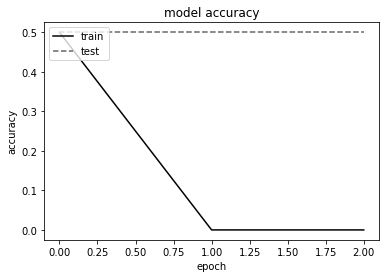

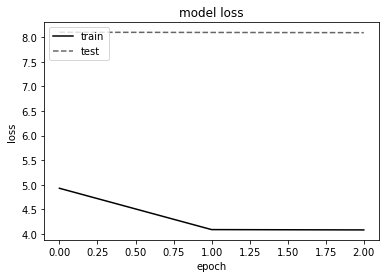

In [21]:
model.save(SaveModelFolder)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(rootfolder + 'ModelAccuracy.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(rootfolder + 'ModelLoss.png')
plt.show()